# DATA 604 - Final Project (Sie Siong Wong)

## Problem Statement
The simulation topic for my final project is how is changing the number of bank tellers might affect the waiting time for clients. Bank executives don't want to hire too many tellers, and too little tellers that can cause customers to wait in line too long which cause customer dissatisfaction. This goal of developing this simulation program is to help bank executives to determine an optimal number of tellers they want to hire for such as new or existing bank branch locations. 

This study excludes the clients who walk in to look for bankers e.g. opening a checking acocunt, applying for housing loan, etc. The waiting line in this simulation program is the line to help clients for handling routine transactions such deposit, withdrawal, etc.

- Inter-Arrival Times: Arrivals waiting for next available teller
- Entities: Clients
- Activity Times: Times spent in the waiting line
- Resources: Tellers

## Flow Chart Model


<img src="https://github.com/SieSiongWong/DATA-604/blob/main/Final%20Project/Flow-Chart%20Model.png?raw=true">

## Simulate the Process

In [1]:
import simpy
import random
import numpy as np
from modsim import *
from random import seed, expovariate

# Create a timeframe to store activity times
frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                           'time_serve','time_in_queue','time_finished_at'])

# Generator function for bringing new clients into the model
def client_generator(env, mean_inter_arrival_time, mean_serve_time, teller):
    
    """ env = simulation environment 
        mean_inter_arrival_time =  mean inter-arrival time for clients coming in
        mean_serve_time =  mean time clients spend with a teller
        teller =  teller resource """
    
    # Initiate client id
    c_id = 0
    
    # Keep doing this indefinitely
    while True:
        
        # Create an instance of client activity generator
        wp = activity_generator(env, mean_serve_time, teller, c_id)
        
        # Run the activity generator
        env.process(wp)
        
        # Calculate the time until next cient arrives using randomly exponential distribution
        t = random.expovariate(1.0 / mean_inter_arrival_time)
        
        # Freeze this function until inter-arrival time has elapsed
        yield env.timeout(t)
        
        # Increment the client id after inter-arrival time has elapsed
        c_id += 1

# Generator function for the activities that clients will queue for
def activity_generator(env, mean_serve_time, teller, c_id):
        
    """ env = simulation environment 
        mean_serve_time =  mean time clients spend with a teller
        teller =  teller resource 
        c_id = client id """
    
    # Grab a current simulation time when a client start to queue
    time_entered_queue_for_client = env.now
    frame.at[c_id, 'client_id'] = c_id
    frame.at[c_id, 'time_entered_queue'] = time_entered_queue_for_client
    #print("Client ", c_id, " entered queue at ", time_entered_queue_for_client, sep="")
    
    # Use a "with" statement to indicate that all the codes within it needs to be done before it can released
    # Call the request function of the client resource
    with teller.request() as req:
        
        # Call a yield until a teller is available
        yield req
        
        # Grab the current simulation time clients left queue 
        time_left_queue_for_client = env.now
        frame.at[c_id, 'time_left_queue'] = time_left_queue_for_client
        #print("Client ", c_id, " left queue at ", time_left_queue_for_client, sep="")
        
        # Calcualte the time clients spend in waiting line
        time_in_queue_for_client = (time_left_queue_for_client - time_entered_queue_for_client)
        frame.at[c_id, 'time_in_queue'] = time_in_queue_for_client
        #print("Client ", c_id, " queued for ", time_in_queue_for_client, " minutes.", sep="")
        
        # Calculate the time clients spend with a teller using randomly exponential distribution
        sampled_serve_time = random.expovariate(1.0 / mean_serve_time)
        frame.at[c_id, 'time_serve'] = sampled_serve_time
        
        # Freeze this function until served time has elapsed
        yield env.timeout(sampled_serve_time)
        frame.at[c_id, 'time_finished_at'] = env.now
        #print("***Client ", c_id, " finished at ", env.now, sep="")

def run_simulation(capacity, arrival_time, serve_time):
    
    # Setup a simpy environment
    env = simpy.Environment()
    
    # Create a simpy resource and give it to the simulation environment and the capacity
    # Capacity here is the number teller available.
    teller = simpy.Resource(env, capacity=capacity)

    # Set model parameter values where mean_inter_arrival is the mean inter-arrival time for clients coming in, 
    # and mean_served is the mean time clients will spend with a teller.
    mean_inter_arrival_time = arrival_time
    mean_serve_time = serve_time

    # Set seed
    seed(12345)

    # Startup client generator function to start creating new clients
    env.process(client_generator(env, mean_inter_arrival_time, mean_serve_time, teller))

    # Set the simulation to run for 480 minutes (8 hours)
    env.run(until=480)
    
    # Calculate the idle time of no customers to serve until next customer arrival
    for c_id in range(len(frame)):
        if frame.at[c_id,'client_id'] == 0:
            frame.at[c_id, 'time_idle'] = 0
        
        elif frame.at[c_id, 'time_entered_queue'] - frame.at[c_id-1, 'time_finished_at'] < 0:
            frame.at[c_id, 'time_idle'] = 0
    
        else:
            frame.at[c_id, 'time_idle'] = frame.at[c_id, 'time_entered_queue'] - frame.at[c_id-1, 'time_finished_at']
 
    return frame
        

## Results

The dataframe below shows the top 25 rows result of simulation with parameter values of 2 (capacity), 2.5 (mean inter-arrival time), and 3 (serving time).

From this dataframe, we can see how the time elapsed from a client started queueing in the waiting line, served by a teller, to leaving the bank. For example, the client 0 arrived at the bank without queueing and went straight to the counter and left bank at 0.030664 minutes. All tellers have been idled for 1.316627 minutes until the second client (id=1) arrived at the bank at 1.347291 minutes. 

The same process continued for the rest of clients. However, this process flow does not finish in the sequence as some tellers might take longer to serve the client. That is why you can see the client 4 served by a teller finished at 10.645134 minutes while client 5 served by another teller finished at 9.849748 minutes.

In [2]:
run_simulation(2, 2.5, 3).head(25)

,client_id,time_idle,time_entered_queue,time_left_queue,time_serve,time_in_queue,time_finished_at
0,0,0,0,0,0.030664,0,0.030664
1,1,1.316627,1.347291,1.347291,1.064201,0.0,2.411492
2,2,3.296174,5.707666,5.707666,0.645754,0.0,6.35342
3,3,0.503039,6.85646,6.85646,0.529094,0.0,7.385554
4,4,1.55773,8.943284,8.943284,1.701851,0.0,10.645134
5,5,0,9.275018,9.275018,0.57473,0.0,9.849748
6,6,1.489559,11.339307,11.339307,1.315056,0.0,12.654363
7,7,0.699172,13.353536,13.353536,0.287201,0.0,13.640737
8,8,7.641872,21.282609,21.282609,1.593694,0.0,22.876303
9,9,8.021893,30.898197,30.898197,0.481021,0.0,31.379218


Now let's do some plots to visualize how parameter value changed affect the average waiting time and total idling time.

Below plot shows the average waiting time with variation of mean inter-arrival time with 2 tellers and mean serving time of 3 minutes. The average waiting time dropped sharply when the gap of client arrival time is at 1.5 minute and continue to have lower average waiting time for higher mean inter-arrival time.

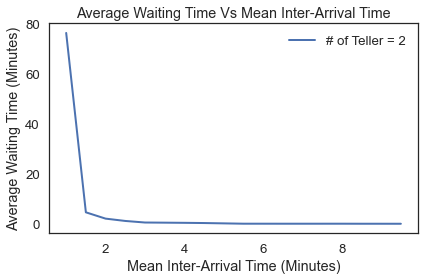

In [3]:
# Plot to show average waiting time vs inter-arrival times
mean_inter_arrival_array = linrange(1,10,0.5)
avg_wait_time = SweepSeries()

for inter_arrival in mean_inter_arrival_array:
    
    # Create a timeframe to store activity times
    frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                                'time_serve','time_in_queue','time_finished_at'])
    
    avg_wait_time[inter_arrival] = run_simulation(2, inter_arrival, 3)['time_in_queue'].mean()

plot(avg_wait_time, label='# of Teller = ' + str(2))

decorate(xlabel='Mean Inter-Arrival Time (Minutes)',
         ylabel='Average Waiting Time (Minutes)',
         title = 'Average Waiting Time Vs Mean Inter-Arrival Time')

The average waiting time decreased as the inter-arrival time increased. This makes sense since the bigger the gap between clients arrived, tellers will have more times to handle transactions and less number clients queue at the waiting line. Also, we can see from the plot that 2 tellers or higher has average waiting time close to zero for mean inter-arrival time 1.5 minutes or higher.

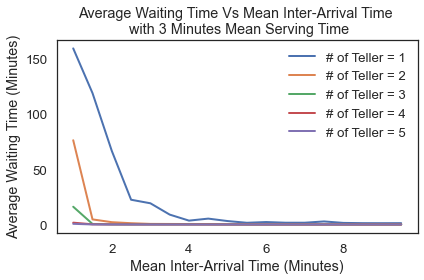

In [4]:
# Plot to show average waiting time vs mean inter-arrival with a range of capacity (# of tellers)
mean_inter_arrival_array = linrange(1,10,0.5)
capacity_array = linrange(1,6)
avg_wait_time = SweepSeries()

for capacity in capacity_array:
    for inter_arrival in mean_inter_arrival_array:
        
        # Create a timeframe to store activity times
        frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                                   'time_serve','time_in_queue','time_finished_at'])
        
        avg_wait_time[inter_arrival] = run_simulation(capacity, inter_arrival, 3)['time_in_queue'].mean()
    
    label = '# of Teller = ' + str(capacity)
    plot(avg_wait_time, label=label)

decorate(xlabel='Mean Inter-Arrival Time (Minutes)',
         ylabel='Average Waiting Time (Minutes)',
         title = 'Average Waiting Time Vs Mean Inter-Arrival Time \n with 3 Minutes Mean Serving Time')


The average waiting time increased as the mean serving time increased. The longer it takes for a teller to handle transactions, there are less tellers available for the coming clients and higher waiting time for clients in the queue line. It's interesting to see that the trends of average waiting time for 4 tellers or higher has not been affected by longer serving time. It's close to zero average waiting time.  

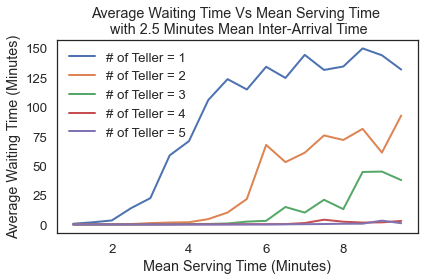

In [5]:
mean_serve_time_array = linrange(1,10,0.5)
capacity_array = linrange(1,6)
avg_wait_time = SweepSeries()

for capacity in capacity_array:
    for serve_time in mean_serve_time_array:
        
        # Create a timeframe to store activity times
        frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                                   'time_serve','time_in_queue','time_finished_at'])
        
        avg_wait_time[serve_time] = run_simulation(capacity, 2.5, serve_time)['time_in_queue'].mean()
    
    label = '# of Teller = ' + str(capacity)
    plot(avg_wait_time, label=label)

decorate(xlabel='Mean Serving Time (Minutes)',
         ylabel='Average Waiting Time (Minutes)',
         title = 'Average Waiting Time Vs Mean Serving Time \n with 2.5 Minutes Mean Inter-Arrival Time')

As more tellers are available to serve clients, the total idle time is also increased. 3 tellers or higher shows the same trend. When there is only one teller, it has significant less idle time compared to 2 or more tellers in place. This is shown in the plot below.

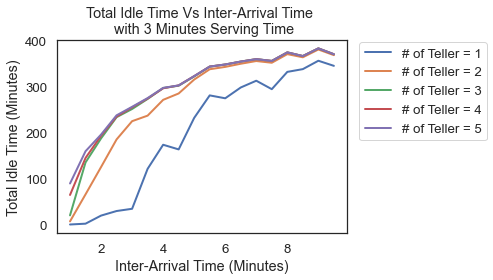

In [6]:
# Plot to show total idle time versus inter-arrival time
mean_inter_arrival_array = linrange(1,10,0.5)
capacity_array = linrange(1,6)
total_idle_time = SweepSeries()

plt.figure(figsize=(7, 4))

for capacity in capacity_array:
    for inter_arrival in mean_inter_arrival_array:
        
        # Create a timeframe to store activity times
        frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                            'time_serve','time_in_queue','time_finished_at'])
        
        total_idle_time[inter_arrival] = run_simulation(capacity, inter_arrival, 3)['time_idle'].sum()
    label = '# of Teller = ' + str(capacity)
    plot(total_idle_time, label=label)

decorate(xlabel='Inter-Arrival Time (Minutes)',
         ylabel='Total Idle Time (Minutes)',
         title = 'Total Idle Time Vs Inter-Arrival Time \n with 3 Minutes Serving Time',
         loc = 'upper left')

plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.tight_layout()

The plot below shows the total idle time started to decrease as the mean serving time increased. This makes a lot of sense because the longer it takes for tellers to handling transactions, they will have less idle time. The total idle time reached close to zero at 4.5 minutes mean serving time when only one teller in place. 

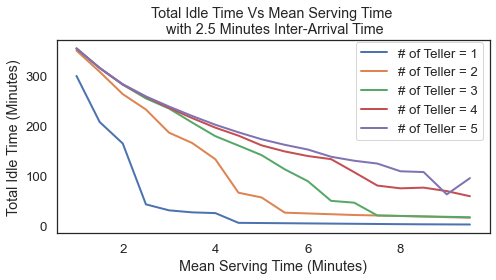

In [7]:
# Plot to show total idle time versus mean serving time
mean_serve_time_array = linrange(1,10,0.5)
capacity_array = linrange(1,6)
total_idle_time = SweepSeries()

plt.figure(figsize=(7, 4))

for capacity in capacity_array:
    for serve_time in mean_serve_time_array:
        
        # Create a timeframe to store activity times
        frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                                   'time_serve','time_in_queue','time_finished_at'])
        
        total_idle_time[serve_time] = run_simulation(capacity, 2.5, serve_time)['time_idle'].sum()
    
    label = '# of Teller = ' + str(capacity)
    plot(total_idle_time, label=label)

decorate(xlabel='Mean Serving Time (Minutes)',
         ylabel='Total Idle Time (Minutes)',
         title = 'Total Idle Time Vs Mean Serving Time \n with 2.5 Minutes Inter-Arrival Time',
         loc = 'upper left')

plt.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

The higher the mean inter-arrival time, the less clients tellers will serve per working day. This indicates that higher mean serving time may not necessary impact the average wating time if inter-arrival time between clients is high enough. 

The total number of clients that tellers can serve per working day varies for different mean serving time and number of tellers. But I'm getting an exponential distribution curve for plotting total clients against the variation of mean inter-arrival time. This makes sense as I used the randomized exponential distribution method to assign an inter-arrival timing for each client entering the queue. You can visualize below two plots for these results. 

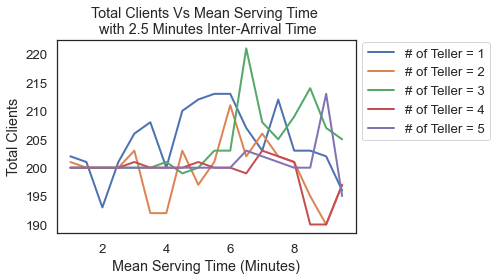

In [8]:
# Plot to show total number of clients versus mean serving time
mean_serve_time_array = linrange(1,10,0.5)
capacity_array = linrange(1,6)
total_clients = SweepSeries()

plt.figure(figsize=(7, 4))

for capacity in capacity_array:
    for serve_time in mean_serve_time_array:
        
        # Create a timeframe to store activity times
        frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                                   'time_serve','time_in_queue','time_finished_at'])
        
        total_clients[serve_time] = len(run_simulation(capacity, 2.5, serve_time)['client_id'])
    
    label = '# of Teller = ' + str(capacity)
    plot(total_clients, label=label)

decorate(xlabel='Mean Serving Time (Minutes)',
         ylabel='Total Clients',
         title = 'Total Clients Vs Mean Serving Time \n with 2.5 Minutes Inter-Arrival Time',
         loc = 'upper left')

plt.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

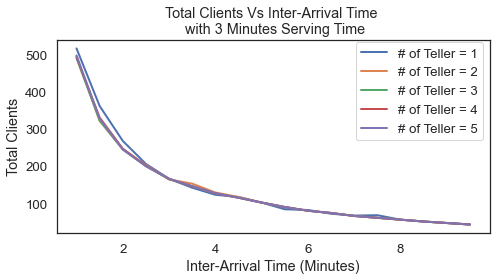

In [9]:
# Plot to show total number of clients versus mean inter-arrival time
mean_inter_arrival_array = linrange(1,10,0.5)
capacity_array = linrange(1,6)
total_clients = SweepSeries()

plt.figure(figsize=(7, 4))

for capacity in capacity_array:
    for inter_arrival in mean_inter_arrival_array:
        
        # Create a timeframe to store activity times
        frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                            'time_serve','time_in_queue','time_finished_at'])
        
        total_clients[inter_arrival] = len(run_simulation(capacity, inter_arrival, 3)['client_id'])
    label = '# of Teller = ' + str(capacity)
    plot(total_clients, label=label)

decorate(xlabel='Inter-Arrival Time (Minutes)',
         ylabel='Total Clients',
         title = 'Total Clients Vs Inter-Arrival Time \n with 3 Minutes Serving Time',
         loc = 'upper left')

plt.legend(bbox_to_anchor=(1.00, 1.02))
plt.tight_layout()

## Verification and Validation

From above results, we can clearly see that 2 tellers is the optimal number of tellers to hire. 1 teller definitely is not adequate to handle day to day transactions requested from clients. Also, it'll require much higher mean inter-arrival time e.g. 9 minutes and much lower mean serving time e.g. 2 minutes to achieve 3 minutes or lower average waiting time. This may not be happening in a reality world unless the bank business is not doing well. 3 tellers or more will be a waste as idling time will be much higher. 

According to this similar simulation [**article**](https://dl.acm.org/doi/pdf/10.1145/224401.224776) (*Hammond and Mahesh 1995*), majority of the banks has a desired policy to provide service for their clients within 3 minutes. In the artcle, it also mentioned that "*The two tellers calculated to be adequate 95 % of the time under average conditions provided the desired level of service only 68 % of the time in the simulation model.*". The similar result was obtained in this simulation where the percentage of clients whose waiting time was 3 minutes or less is 71%.

The optimal parameter values indicated from the simulation results above are 3 minutes of mean inter-arrival time and 5.5 minutes of serving as shown in below. Below calculation results verify and justify the validity of the simulation model.

In [10]:
frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                                'time_serve','time_in_queue','time_finished_at'])
print("Average waiting time is ", run_simulation(2, 3, 5.5)['time_in_queue'].mean(), " minutes")

Average waiting time is  2.460972554543405  minutes


In [11]:
frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                                'time_serve','time_in_queue','time_finished_at'])
print("Total idle time is ", run_simulation(2, 3, 5.5)['time_idle'].sum(), " minutes")

Total idle time is  98.46303053621017  minutes


In [12]:
count_3min = run_simulation(2, 3, 5.5).apply(lambda x : True if x['time_in_queue'] < 3 else False, axis = 1)
pct_3min = round(np.sum(count_3min)/len(count_3min)*100, 2)

print("The percentage of clients whose waiting time is 3 minutes or less is ", pct_3min, "%")

The percentage of clients whose waiting time is 3 minutes or less is  70.97 %


## Conclusions

To conclude, this bank teller simulation study has demonstrated that bank executives can use this simulation program to figure out the optimal number of tellers based on the mean inter-arrival time and the mean serving time for a client. They can choose reasonable parameters values based on bank location conditions to simulate. The number of clients coming in every working day looking for tellers vary greatly across different regions and communities. Factors that may affect the number of clients per branch per working day such as number of existing clients living in the area, number of competitors doing business in the same area,  acquire more new clients, and so on. For example, the bank located in high population density areas like Manhattan will require much more tellers. One of the bank locations I used to go required 8 tellers but the waiting line was still very long. It requires executives to have a good estimate of mean inter-arrival time and mean serving time in order to use this simulation program to find out the optimal number of tellers.